 The previous lecture demonstrated some amazing powers of multiple regression. It can smoke out spurious correlations and clear up masking effects. 
 This may encourage the view that, when in doubt, just add everything to the model and let the oracle of regression sort it out.
 
This chapter and the next are both about terrible things that can happen when we simply
add variables to a regression, without a clear idea of a causal model. 
In this chapter, we’ll explore
three different hazards: multicollinearity, post-treatment bias, and collider bias. 


In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit



<h1>Multicollinearity</h1>

It is commonly true that there are many potential predictor variables to add to a regression
model. In the case of the primate milk data, for example, there are 7 variables available
to predict any column we choose as an outcome. Why not just fit a model that includes all
7? There are several hazards. The one we’ll focus on here is multicollinearity. Multicollinearity
means very strong correlation between two or more predictor variables.
The consequence of it is that the posterior distribution will seem to suggest that none of the variables
is reliably associated with the outcome, even if all of the variables are in reality strongly
associated with the outcome. This frustrating phenomenon arises from the details of how
multiple regression works. In fact, there is nothing wrong with multicollinearity. The model
will work fine for prediction. You will just be frustrated trying to understand it. The hope is
that once you understand multicollinearity, you will better understand regression models in
general.
Let’s begin with a simple simulation. Then we’ll turn to the primate milk data again and
see multicollinearity in a real data set.





The simulation example is predicting an individual’s height using
the length of his or her legs as predictor variables. Surely height is positively associated
with leg length, or at least the simulation will assume it is. Nevertheless, once you put both
leg lengths into the model, something vexing will happen.
The code below will simulate the heights and leg lengths of 100 individuals. For each,
first a height is simulated from a Gaussian distribution. Then each individual gets a simulated
proportion of height for their legs, ranging from 0.4 to 0.5. Finally, each leg is salted with a
little measurement or developmental error, so the left and right legs are not exactly the same
length, as is typical in real populations. At the end, the code puts height and the two leg
lengths into a common data frame.

In [2]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(
    0, 0.02, N
)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(
    0, 0.02, N
)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()
d.describe()

,height,leg_left,leg_right
count,100.000000,100.000000,100.000000
mean,10.022909,4.525385,4.531786
std,1.733838,0.844473,0.842108
min,5.625724,2.812547,2.815829
25%,8.894380,3.908568,3.919682
50%,9.616304,4.406619,4.393544
75%,11.416339,5.087926,5.099140
max,16.037942,7.920377,7.895651


In [3]:
with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100)         #Those posterior means and standard deviations look crazy. This is a case in which a graphical

    
    bl = pm.Normal("bl", 2, 10)      #view of the precis output is more useful, because it displays the posterior means and 89%

    br = pm.Normal("br", 2, 10)

    mu = a + bl * d.leg_left + br * d.leg_right #intervals in a way that allows us with a glance to see that something has gone wrong here:
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    m_6_1_trace = pm.sample()
    idata_6_1 = az.from_pymc3(
        m_6_1_trace
    )  # create an arviz InferenceData object from the trace.
    # this happens automatically when calling az.summary, but as we'll be using this trace multiple
    # times below it's more efficient to do the conversion once at the start.

az.summary(idata_6_1, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 276 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.36,0.36,0.69,2.04,0.01,0.01,840.67,840.67,864.00,912.56,1.01
bl,1.00,2.35,-3.16,5.57,0.10,0.08,527.70,491.36,525.52,583.31,1.01
br,0.91,2.36,-3.62,5.19,0.10,0.08,530.48,440.56,527.10,585.60,1.01
sigma,0.65,0.05,0.58,0.74,0.00,0.00,117.25,117.25,89.10,190.26,1.02


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['mu'] have not been found and will be ignored
  warnings.warn(


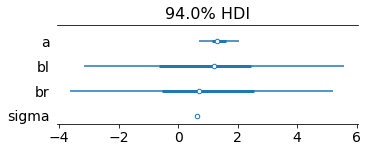

In [5]:
_ = az.plot_forest(m_6_1_trace, var_names=["~mu"], combined=True, figsize=[5, 2])

If both legs have almost identical lengths, and height is so strongly associated with leg length, then why
is this posterior distribution so weird? Did the posterior approximation work correctly?It did work correctly, and the posterior distribution here is the right answer to the question
we asked. 
The problem is the question. Recall that a multiple linear regression answers
the question: What is the value of knowing each predictor, after already knowing all of the
other predictors? 
<b>So in this case, the question becomes: What is the value of knowing each
leg’s length, after already knowing the other leg’s length?</b>

The answer to this weird question is equally weird, but perfectly logical. The posterior
distribution is the answer to this question, considering every possible combination of the
parameters and assigning relative plausibilities to every combination, conditional on this
model and these data. It might help to look at the bivariate posterior distribution for bl and
br:

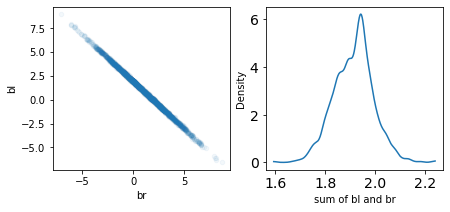

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

# code 6.5
ax1.scatter(m_6_1_trace[br], m_6_1_trace[bl], alpha=0.05, s=20)
ax1.set_xlabel("br")
ax1.set_ylabel("bl")

# code 6.6
az.plot_kde(m_6_1_trace[br] + m_6_1_trace[bl], ax=ax2)
ax2.set_ylabel("Density")
ax2.set_xlabel("sum of bl and br");



The posterior distribution for these
two parameters is very highly correlated, with all of the plausible values of bl and br lying
along a narrow ridge. When bl is large, then br must be small. What has happened here
is that since both leg variables contain almost exactly the same information, if you insist on
including both in a model, then there will be a practically infinite number of combinations
of bl and br that produce the same predictions.
One way to think of this phenomenon is that you have approximated this model:

yi ∼ Normal(μi, σ)
μi = α + β1xi + β2xi

The variable y is the outcome, like height in the example, and x is a single predictor, like the leg
lengths in the example. Here x is used twice, which is a perfect example of the problem caused
by using the almost-identical leg lengths. From the computer’s perspective, this model is
simply:

yi ∼ Normal(μi, σ)
μi = α + (β1 + β2)xi

All I’ve done is factor xi out of each term. The parameters β1 and β2 cannot be pulled apart,
because they never separately influence the mean μ. Only their sum, β1+β2, influences μ. So
this means the posterior distribution ends up reporting the very large range of combinations
of β1 and β2 that make their sum close to the actual association of x with y.

In [11]:
with pm.Model() as m_6_2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)

    mu = a + bl * d.leg_left
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    m_6_2_trace = pm.sample()
    idata_m_6_2 = az.from_pymc3(m_6_2_trace)

az.summary(idata_m_6_2, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.655700732459104, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.68,0.32,0.10,1.28,0.01,0.01,555.80,535.75,555.81,616.42,1.01
bl,2.07,0.07,1.95,2.20,0.00,0.00,559.04,559.04,560.45,583.16,1.01
sigma,0.64,0.05,0.56,0.72,0.00,0.00,242.91,242.91,214.30,132.16,1.01


<h1> Real data multi colinearity</h1>

In [7]:
d = pd.read_csv("Data/milk.csv", sep=";")


def standardise(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


d.loc[:, "K"] = standardise(d["kcal.per.g"])
d.loc[:, "F"] = standardise(d["perc.fat"])
d.loc[:, "L"] = standardise(d["perc.lactose"])


In this example, we are concerned with the variables perc.fat (percent fat) and perc.lactose
(percent lactose) that we might use to model the total energy content, kcal.per.g. The code
above has already standardized these three variables. You’re going to use these three variables
to explore a natural case of multicollinearity.

In [8]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)

    mu = a + bF * d.F
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K)

    m_6_3_trace = pm.sample()
    idata_m_6_3 = az.from_pymc3(m_6_3_trace)

az.summary(idata_m_6_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.16,0.15,0.0,0.0,2501.88,650.07,2499.74,1255.16,1.0
bF,0.86,0.09,0.68,1.02,0.0,0.0,2226.20,2226.20,2240.14,1430.53,1.0
sigma,0.49,0.06,0.38,0.61,0.0,0.0,1861.58,1801.05,1882.30,1188.53,1.0


In [9]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bL * d.L
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K)

    m_6_4_trace = pm.sample()
    idata_m_6_4 = az.from_pymc3(m_6_4_trace)

az.summary(idata_m_6_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.13,0.13,0.0,0.0,2159.20,1287.28,2149.64,1746.69,1.0
bL,-0.90,0.08,-1.04,-0.75,0.0,0.0,1910.55,1910.55,1996.50,1427.80,1.0
sigma,0.41,0.06,0.31,0.52,0.0,0.0,2162.13,2078.04,2226.97,1415.96,1.0


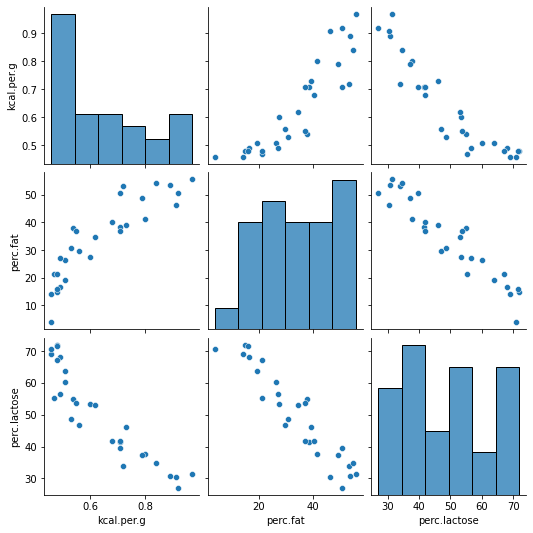

In [10]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

But watch what happens when we
place both predictor variables in the same regression model:

In [11]:
with pm.Model() as m_6_5:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bF * d.F + bL * d.L
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K)

    m_6_5_trace = pm.sample()
    idata_m_6_5 = az.from_pymc3(m_6_5_trace)

az.summary(idata_m_6_5, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, bF, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.13,0.13,0.00,0.00,1369.83,1003.25,1367.52,1373.62,1.0
bF,0.25,0.20,-0.12,0.62,0.01,0.01,774.69,680.87,777.93,892.66,1.0
bL,-0.67,0.20,-1.06,-0.32,0.01,0.01,707.57,707.57,705.91,840.30,1.0
sigma,0.41,0.06,0.31,0.53,0.00,0.00,854.10,843.22,841.68,581.59,1.0


Now the posterior means of both bF and bL are closer to zero. And the standard deviations
for both parameters are twice as large as in the bivariate models
both parameters are twice as large as in the bivariate models 
.
This is the same statistical phenomenon as in the leg length example. What has happened
is that the variables perc.fat and perc.lactose contain much of the same information.
They are almost substitutes for one another. As a result, when you include both in a regression,
the posterior distribution ends up describing a long ridge of combinations of bF and
bL that are equally plausible.

In [12]:


d.corr()['perc.fat']['perc.lactose']



-0.9416373456839282


What is likely going on in the milk example is that there is a core tradeoff in milk composition
that mammal mothers must obey. If a species nurses often, then the milk tends to
be watery and low in energy. Such milk is high in sugar (lactose). If instead a species nurses
rarely, in short bouts, then the milk needs to be higher in energy. Such milk is very high in
fat. This implies a causal model something like this: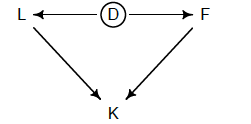

The central tradeoff decides how dense, D, the milk needs to be. We haven’t observed this
variable, so it’s shown circled. Then fat, F, and lactose, L, are determined. Finally, the composition
of F and L determines the kilocalories, K. If we could measure D, or had an evolutionary
and economic model to predict it based upon other aspects of a species, that would
be better than stumbling through regressions. We’d just regression K on D, ignoring the
mediating L and F, to estimate the causal influence of density on energy.

<h1>Post treatment bias </h1>:

mistaken inferences arising from including variables that are consequences of other variables.


The language “post-treatment” comes in fact from thinking about experimental designs.
Suppose for example that you are growing some plants in a greenhouse. 
You want to know the difference in growth under different anti-fungal soil treatments, because fungus on the
plants tends to reduce their growth. 

Plants are initially seeded and sprout. Their heights are
measured. 
Then different soil treatments are applied.
Final measures are the height of the plant and the presence of fungus.
There are four variables of interest here: initial height, final
height, treatment, and presence of fungus.
Final height is the outcome of interest. But which
of the other variables should be in the model? If your goal is to make a causal inference about
the treatment, you shouldn’t include the presence of fungus, because it is a post-treatment
effect

In [13]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict(
    {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus}
)

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
h0,10.14,2.25,5.26,13.95
h1,14.05,2.86,9.46,19.77
treatment,0.50,0.50,0.00,1.00
fungus,0.33,0.47,0.00,1.00


In [14]:
d

,h0,h1,treatment,fungus
0,8.532252,13.611465,0,0
1,7.733635,12.294476,0,0
2,8.644448,12.518087,0,1
3,11.002251,13.769644,0,1
4,11.182568,16.788117,0,0
...,...,...,...,...
95,9.391210,14.457653,1,0
96,15.427471,20.772448,1,0
97,5.528762,11.529550,1,0
98,12.411713,16.820794,1,0


<h2>A prior is born</h2>

. When designing the model, it helps to pretend you don’t have the
data generating process just above. In real research, you will not know the real data generating
process. But you will have a lot of scientific information to guide model construction.


So let’s spend some time taking this mock analysis seriously.
We know that the plants at time t = 1 should be taller than at time t = 0, whatever scale
they are measured on. So if we put the parameters on a scale of proportion of height at time
t = 0, rather than on the absolute scale of the data, we can set the priors more easily. To
make this simpler, let’s focus right now only on the height variables, ignoring the predictor 
variables. We might have a linear model like:


h1,i ∼ Normal(μi, σ)

μi = h0,i × p


where p is a parameter
measuring the proportion of h0,i that h1,i is. More precisely, p = h1,i/h0,i.
If p = 1, the plant
hasn’t changed at all from time t = 0 to time t = 1. If p = 2, it has doubled in height. So
if we center our prior for p on 1, that implies an expectation of no change in height. That
is less than we know. But we should allow p to be less than 1, in case the experiment goes
horribly wrong and we kill all the plants. We also have to ensure that p > 0, because it is a
proportion.

Let’s fit this model, so
you can see how it just measures the average growth in the experiment.




In [15]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,1.04,0.26,0.59,1.53


So this prior expects anything from 40% shrinkage up to 50% growth. Let’s fit this model, so
you can see how it just measures the average growth in the experiment

In [16]:
with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.37,0.02,1.33,1.40,0.0,0.0,1670.37,1669.23,1662.65,1412.36,1.0
sigma,1.93,0.13,1.69,2.19,0.0,0.0,2046.52,2041.45,2047.36,1440.47,1.0


The model expexts 40 % growth on average. How to include the treatment and fungus variables? We’ll
include both of them, following the notion that we’d like <b>to measure the impact of both the
treatment and the fungus</b> itself. The parameters for these variables will also be on the proportion
scale. They will be changes in proportion growth. So we’re going to make a linear model of p now.



h <sub>1,i</sub> ∼ Normal(μ<sub>i</sub>, σ)

μ<sub>i</sub> = h<sub>0,i</sub> × p

p = α + β<sub>T</sub>T<sub>i</sub> + β<sub>F</sub>F<sub>i</sub>

α ∼ Log-Normal(0, 0.25)

β<sub>T</sub> ∼ Normal(0, 0.5)

β <sub>F</sub>∼ Normal(0, 0.5)

σ ∼ Exponential(1)


In [17]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample()

az.summary(m_6_7_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.878854568252156, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.47,0.03,1.42,1.52,0.0,0.0,873.87,873.87,871.93,1040.27,1.0
bt,-0.04,0.03,-0.10,0.02,0.0,0.0,888.34,860.54,880.43,1217.64,1.0
bf,-0.28,0.03,-0.34,-0.21,0.0,0.0,982.79,982.79,986.14,1269.57,1.0
sigma,1.43,0.10,1.25,1.64,0.0,0.0,1272.20,1272.20,1275.24,1044.76,1.0


The marginal posterior for bt, the effect of treatment, is solidly zero, with a tight interval. 
The treatment is not associated with growth.
The fungus seems to have hurt growth, however. Given that we
know the treatment matters, because we built the simulation that way, what happened here?
<h2> Blocked by consequence.</h2>

The problem is that fungus is mostly a consequence of
treatment.
This is to say that fungus is a post-treatment variable.
So when we control for fungus, the model is implicitly answering the question:
Once we already know whether or not a plant developed fungus, does soil treatment matter?
The answer is “no,” because soil treatment has its effects on growth through reducing fungus. 
But we actually want to know,
based on the design of the experiment, is the impact of treatment on growth. To measure
this properly, we should omit the post-treatment variable fungus. Here’s what the inference
looks like in that case:

In [18]:
with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample()

az.summary(m_6_8_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.30,0.03,1.25,1.35,0.0,0.0,984.10,984.10,983.88,1036.70,1.00
bt,0.10,0.04,0.03,0.17,0.0,0.0,828.25,828.25,831.75,990.93,1.01
sigma,1.91,0.14,1.63,2.15,0.0,0.0,1368.56,1361.91,1372.84,1217.81,1.00


Now the impact of treatment is clearly positive, as it should be. It makes sense to control
for pre-treatment differences, like the initial height h0, that might mask the causal influence
of treatment. But including post-treatment variables can actually mask the treatment itself.
This doesn’t mean you don’t want the model that includes both treatment and fungus. The
fact that <b>including fungus zeros the coefficient for treatment suggests that the treatment
works for exactly the anticipated reasons</b>. It tells us about mechanism. But a correct inference
about the treatment still depends upon omitting the post-treatment variable.

<h2>Fungus and d-separation </h2>. It helps to look at this problem in terms of a DAG.

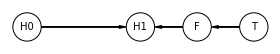

In [19]:
import daft

from causalgraphicalmodels import CausalGraphicalModel

plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()


So the treatment T influences the presence of fungus F which influences plant height at time
1, H1.

Plant height at time 1 is also influenced by plant height at time 0, H0. 

That’s ourDAG. When we include <h3> F, the post-treatment effect, in the model, we end up blocking the
path </h3>from the treatment to the outcome.

This is the DAG way of saying that learning the treatment tells us nothing about the outcome, once we know the fungus status.
An even more DAG way to say this is that conditioning on F induces d-separation. The
“d” stands for directional.d-separation means that some variables on a directed graph are
independent of others. There is no path connecting them. 

In this case, H1 is d-separated from T, but only when we condition on F. 
Conditioning on F effectively blocks the directed path T → F → H1, making T and H1 independent (d-separated). 
In the previous chapter, you saw
the notation H1 ⊥⊥ T|F for this kind of statement, when we discussed implied conditional
independencies. Why does this happen? There is no information in T about H1 that is not
also in F. So once we know F, learning T provides no additional information about H1. You
can query the implied conditional independencies for this DAG:

In [20]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)
# F _||_ H0
# H0 _||_ T
#H1 _||_ T | F
#

('H1', 'T', {'F'})
('H0', 'T', set())
('H0', 'F', set())


Obviously the problem of post-treatment variables applies just as well to observational
studies as it does to experiments
. But in experiments, it can be easier to tell which variables
are pre-treatment, like h0, and which are post-treatment, like fungus.
In observational studies,
it is harder to know. But there are some subtle traps in experiments as well.
For example, conditioning on a post-treatment variable can not only fool you into thinking
the treatment doesn’t work. It can also fool you into thinking it does work. Consider the
DAG below:

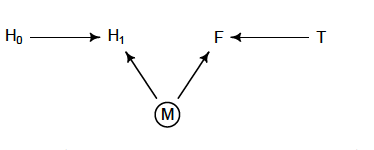

In this graph, the treatment T influences fungus F, but fungus doesn’t influence plant growth.
Maybe the plant species just isn’t bothered by this particular fungus. 
The new variable M is moisture. It influences both H1 and F. M is circled to indicate that it is unobserved.
Any unobserved common cause of H1 and F will do—it doesn’t have to be moisture of course.
A regression of H1 on T will show no association between the treatment and plant growth.
But if we include F in the model, suddenly there will be an association. Let’s try it. I’ll just
modify the plant growth simulation so that fungus has no influence on growth, but moisture
M influences both H1 and F:

In [22]:
N = 1000
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(1, 0.5, size=N)  # assumed probability 0.5 here, as not given in book
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
h0,10.02,1.90,6.46,13.59
h1,16.46,2.51,11.88,21.07
treatment,0.50,0.50,0.00,1.00
fungus,0.49,0.50,0.00,1.00


Rerun the models from earlier, models m6.7 and m6.8, using the data in d2 now. You’ll see
that including fungus again confounds inference about the treatment, this time by making
it seem like it helped the plants, even though it had no effect.

In [23]:
with pm.Model() as m_6_7p:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7p_trace = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.879428971937404, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.47,0.03,1.42,1.52,0.0,0.0,873.87,873.87,871.93,1040.27,1.0
bt,-0.04,0.03,-0.10,0.02,0.0,0.0,888.34,860.54,880.43,1217.64,1.0
bf,-0.28,0.03,-0.34,-0.21,0.0,0.0,982.79,982.79,986.14,1269.57,1.0
sigma,1.43,0.10,1.25,1.64,0.0,0.0,1272.20,1272.20,1275.24,1044.76,1.0


In [24]:
az.summary(m_6_7p_trace, round_to=2)

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.53,0.01,1.51,1.56,0.0,0.0,814.95,814.94,816.57,1036.32,1.0
bt,0.04,0.01,0.02,0.07,0.0,0.0,908.16,908.16,908.44,979.70,1.0
bf,0.13,0.01,0.10,0.16,0.0,0.0,1032.64,1032.64,1037.18,1181.82,1.0
sigma,2.12,0.05,2.03,2.20,0.0,0.0,1472.39,1471.85,1471.36,1393.59,1.0


In [26]:
with pm.Model() as m_6_8p:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8p_trace = pm.sample()

az.summary(m_6_8p_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.62,0.01,1.60,1.64,0.0,0.0,1365.19,1365.19,1370.32,1494.39,1.0
bt,-0.00,0.01,-0.03,0.02,0.0,0.0,1194.10,1171.60,1194.07,1324.54,1.0
sigma,2.19,0.05,2.10,2.29,0.0,0.0,1389.72,1389.07,1391.40,1066.64,1.0


<h2>Collider bias</h2>
The fact that two arrows enter S means it is a collider. The core concept is easy to understand:
When you condition on a collider, it creates statistical—but not necessarily causal—
associations among its causes.
    
    
    

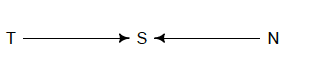

Consider the question of how aging influences happiness. If
we have a large survey of people rating how happy they are, is age associated with happiness?If so, is that association causal? Here, I want to show you how controlling for a plausible
confound of happiness can actually bias inference about the influence of age.89
Suppose, just to be provocative, that an individual’s average happiness is a trait that is
determined at birth and does not change with age. However, happiness does influence events
in one’s life. One of those events is marriage. Happier people are more likely to get married.
Another variable that causally influences marriage is age: The more years you are alive, the
more likely you are to eventually get married. Putting these three variables together, this is
the causal model:

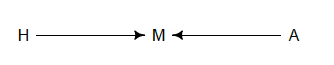

Happiness (H) and age (A) both cause marriage (M). Marriage is therefore a collider. Even
though there is no causal association between happiness and age, if we condition on marriage—
which means here, if we include it as a predictor in a regression—then it will induce a statistical
association between age and happiness. And this can mislead us to think that happiness
changes with age, when in fact it is constant.

To convince us , let’s do another simulation. Simulations are useful in these examples,
because these are the only times when we know the true causal model. If a procedure
cannot figure out the truth in a simulated example, we shouldn’t trust it in a real one. We’re
going to do a simulation  using an agent-based model of aging and marriage
to produce a simulated data set to use in a regression. Here is the simulation design:
(1) Each year, 20 people are born with uniformly distributed happiness values.
(2) Each year, each person ages one year. Happiness does not change.
(3) At age 18, individuals can become married. The odds of marriage each year are
proportional to an individual’s happiness.
(4) Once married, an individual remains married.
(5) After age 65, individuals leave the sample. (They move to Spain.)

In [27]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn
popn = sim_happiness()

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(
    int
)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
age,32.00,18.77,0.0,61.00
happiness,-0.00,1.21,-2.0,1.79
married,0.28,0.45,0.0,1.00


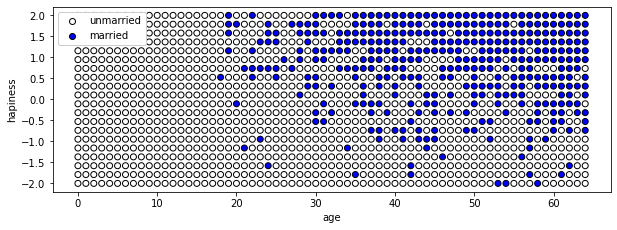

In [28]:
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * popn.shape[0])
colors[popn.married] = "b"
ax.scatter(popn.age, popn.happiness, edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");

Suppose you come across these data and want to ask whether age is related to happiness.
You don’t know the true causal model. But you reason, reasonably, that marriage status
might be an important confound. If married people are more or less happy, on average, then
you need to condition on marriage status in order to infer the relationship between age and
happiness.

So let’s consider a multiple regression model aimed at inferring the influence of age on
happiness, while controlling for marriage status. This is just a plain multiple regression, . The linear model is this:

μi = α<sub>mid<sub>[i]</sub></sub> + β<sub>[A]</sub>A<sub>[i]</sub>


where mid[i] is an index for the marriage status of individual i, with 1 meaning single and
2 meaning married.

<h2>priors</h2> Let’s consider the slope β<sub> A</sub> first,
because how we scale the predictor A will determine the meaning of the intercept. We’ll
focus only on the adult sample, those 18 or over. Imagine a very strong relationship between
age and happiness, such that happiness is at its maximum at age 18 and its minimum at age 65. It’ll be easier if we rescale age so that the range from 18 to 65 is one unit. This will do it:

In [29]:
#adults = popn.loc[popn.age > 17]
#adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18)

adults = popn[popn.age > 17].copy()  # only adults
adults ["A"] = (popn.age - 18) / (65 - 18)

Now this new variable A ranges from 0 to 1, where 0 is age 18 and 1 is age 65. Happiness
is on an arbitrary scale, in these data, from −2 to +2. So our imaginary strongest relationship,
taking happiness from maximum to minimum, has a slope with rise over run of
(2 − (−2))/1 = 4. Remember that 95% of the mass of a normal distribution is contained
within 2 standard deviations. So if we set the standard deviation of the prior to half of 4, we
are saying that we expect 95% of plausible slopes to be less than maximally strong. That isn’t
a very strong prior, but again, it at least helps bound inference to realistic ranges. Now for
the intercepts. Each α is the value of μi when Ai = 0. In this case, that means at age 18. So
we need to allow α to cover the full range of happiness scores. Normal(0, 1) will put 95% of
the mass in the −2 to +2 interval.
Finally, let’s approximate the posterior. We need to construct the marriage status index
variable, as well. 

In [30]:
mid = pd.Categorical(adults.loc[:, "married"].astype(int))

with pm.Model() as m_6_9:
    a = pm.Normal("a", 0, 1, shape=2)# there two a'S
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    m_6_9_trace = pm.sample(1000)

az.summary(m_6_9_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.20,0.07,-0.34,-0.08,0.0,0.0,1093.93,1093.93,1097.11,1066.24,1.0
a[1],1.21,0.10,1.03,1.39,0.0,0.0,1086.12,1076.80,1085.64,972.42,1.0
bA,-0.71,0.13,-0.96,-0.49,0.0,0.0,1044.76,1029.13,1045.93,1056.03,1.0
sigma,1.02,0.02,0.98,1.06,0.0,0.0,1317.97,1315.60,1320.73,1117.67,1.0


The model is quite sure that age is negatively associated with happiness. We’d like to compare
the inferences from this model to a model that omits marriage status.

In [31]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    trace_6_10 = pm.sample(1000)

az.summary(trace_6_10, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.14,0.15,0.0,0.0,1183.77,816.14,1187.33,1050.93,1.0
bA,-0.00,0.14,-0.24,0.27,0.0,0.0,1149.42,808.62,1155.76,1055.73,1.0
sigma,1.22,0.03,1.16,1.27,0.0,0.0,1285.54,1285.54,1280.28,1011.18,1.0


This model, in contrast, finds no association between age and happiness.
The pattern above is exactly what we should expect when we condition on a collider.
The collider is marriage status.

It is a common consequence of age and happiness.
As a result, when we condition on it, we induce a spurious association between the two causes.
So it looks like, to model m6.9, that age is negatively associated with happiness.
But this is just a
statistical association, not a causal association.
Once we know whether someone is married
or not, then their age does provide information about how happy they are.

You can see this in Figure 6.4. Consider only the blue points, the married people.
Among only the blue points, older individuals have lower average happiness.
This is because
more people get married as time goes on, so the mean happiness among married people approaches
the population average of zero. 

Now consider only the open points, the unmarried
people. 
Here it is also true that mean happiness declines with age. This is because happier
individuals migrate over time into the married sub-population.
So in both the married and
unmarried sub-populations, there is a negative relationship between age and happiness. But
in neither sub-population does this accurately reflect causation.
It’s easy to plead with this example. Shouldn’t marriage also influence happiness? What
if happiness does change with age? But this misses the point. If you don’t have a causal
model, you can’t make inferences from a multiple regression. And the regression itself does
not provide the evidence you need to justify a causal model. Instead, you need some science.


<h2>Unmeasured  Causes</h2>

Collider bias arises from conditioning on a common consequence,
as in the previous example. If we can just get our graph sorted, we can avoid it. But it isn’t
always so easy to see a potential collider, because there may be unmeasured causes. Unmeasured
causes can still induce collider bias.



the possibility that our DAG may be haunted.
Suppose for example that we are interested in inferring the direct influence of both parents
(P) and grandparents (G) on the educational achievement of children (C).90 Since grandparents
also presumably influence their own children’s education, there is an arrow G → P.
This sounds pretty easy, so far. It’s similar in structure to our divorce rate example from last example.




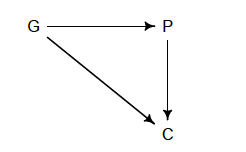

But suppose there are unmeasured, common influences on parents and their children, such
as neighborhoods, that are not shared by grandparents . Then our DAG becomes haunted by the unobserved U:

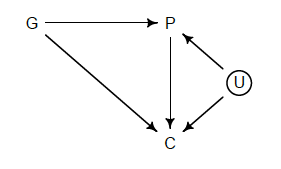

Now P is a common consequence of G and U, so if we condition on P, it will bias inference
about G → C, even if we never get to measure U.
First, let’s simulate 200 triads of grandparents, parents, and children. This simulation
will be simple. We’ll just project our DAG as a series of implied functional relationships. The
DAG above implies that:
(1) P is some function of G and U
(2) C is some function of G, P, and U
(3) G and U are not functions of any other known variables
We can make these implications into a simple simulation, using rnorm to generate simulated
observations. But to do this, we need to be a bit more precise than “some function of.” So I’ll
invent some strength of association:


In [32]:
N = 200  # number of of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # 



These parameters are like slopes in a regression model. Notice that I’ve assumed that grandparents
G have zero effect on their grandkids C. The example doesn’t depend upon that
effect being exactly zero, but it will make the lesson clearer. Now we use these slopes to draw
random observations:

In [33]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

Now what happens when we try to infer the influence of grandparents? Since some of
the total effect of grandparents passes through parents, we realize we need to control for
parents. 
Here is a simple regression of C on P and G. 
the variables are not standardized the . 
the simulated data is kept on its original scale, so you can see what happens to inference about the
slopes above. If we changed the scale, we shouldn’t expect to get those values back. But if
we leave the scale alone, we should be able to recover something close to those values. 


In [34]:
with pm.Model() as m_6_11:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)

    mu = a + p_PC * d.P + p_GC * d.G
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C)

    m_6_11_trace = pm.sample()

az.summary(m_6_11_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_GC, b_PC, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.03,0.10,-0.19,0.17,0.0,0.0,2328.39,1161.87,2326.49,1494.84,1.0
b_PC,1.85,0.04,1.76,1.93,0.0,0.0,1820.52,1808.47,1834.67,1356.09,1.0
b_GC,-0.81,0.10,-0.98,-0.63,0.0,0.0,2019.33,2019.33,2018.60,1683.82,1.0
sigma,1.35,0.07,1.24,1.49,0.0,0.0,2207.55,2207.55,2196.89,1560.05,1.0


The inferred effect of parents looks too big, almost twice as large as it should be. That isn’t
surprising. Some of the correlation between P and C is due to U, and the model doesn’t know
about U. That’s a simple confound. More surprising is that the model is confident that the
direct effect of grandparents is to hurt their grandkids. The regression is not wrong. But a
causal interpretation of that association would be.

How does collider bias arise in this case? Consider Figure 6.5. 
the variables are standirdized to make this plot. So the units on the axes are standard deviations. The
horizontal axis is grandparent education. The vertical is grandchild education. There are
two clouds of points. 
The blue cloud comprises children who live in good neighborhoods
(U = 1). T
he black cloud comprises children who live in bad neighborhoods (U = −1). Notice
that both clouds of points show positive associations between G and C. More educated
grandparents have more educated grandkids, but this effect arises entirely through parents.
Why? Because we assumed it is so. The direct effect of G in the simulation is zero.

Text(0, 0.5, 'grandchild education (C)')

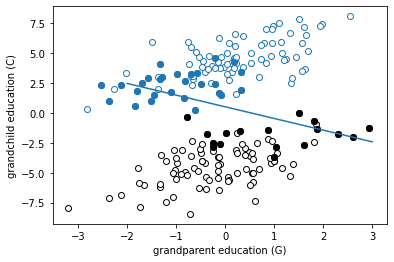

In [19]:
# Figure 6.5

# grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")


p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel("grandparent education (G)")
plt.ylabel("grandchild education (C)")

Why? Because we assumed it is so. The direct effect of G in the simulation is zero.
So how does the negative association arise, when we condition on parents? Conditioning
on parents is like looking within sub-populations of parents with similar education. So let’s
try that. In Figure 6.5, I’ve highlighted in filled points those parents between the 45th and
60th centiles of education. There is nothing special of this range. It just makes the phenomenon
easier to see. Now if we draw a regression line through only these points, regressing
C on G, the slope is negative. There is the negative association that our multiple regression
finds. But why does it exist?


It exists because, once we know P, learning G invisibly tells us about the neighborhood
U, and U is associated with the outcome C. I know this is confusing. As I keep saying, if you
are confused, it is only because you are paying attention. So consider two different parents
with the same education level, say for example at the median 50th centile. One of these
parents has a highly educated grandparent. The other has a poorly educated grandparent.
The only probable way, in this example, for these parents to have the same education is if
they live in different types of neighborhoods. We can’t see these neighborhood effects—we
haven’t measured them, recall—but the influence of neighborhood is still transmitted to the
children C. So for our mythical two parents with the same education, the one with the highly
educated grandparent ends up with a less well educated child. The one with the less educated
grandparent ends up with the better educated child. G predicts lower C.
The unmeasured U makes P a collider, and conditioning on P produces collider bias. So
what can we do about this? You have to measure U.

In [35]:
with pm.Model() as m_6_12:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    p_U = pm.Normal("b_U", 0, 1)

    mu = a + p_PC * d.P + p_GC * d.G + p_U * d.U
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C)

    m_6_12_trace = pm.sample()

az.summary(m_6_12_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_U, b_GC, b_PC, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.883728204172307, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.01,0.07,-0.14,0.12,0.00,0.0,1659.59,784.58,1663.24,1180.42,1.0
b_PC,1.04,0.07,0.91,1.18,0.00,0.0,712.20,708.99,712.25,991.61,1.0
b_GC,-0.01,0.10,-0.18,0.17,0.00,0.0,795.29,795.29,797.07,810.53,1.0
b_U,2.02,0.16,1.73,2.34,0.01,0.0,745.77,745.77,747.73,939.91,1.0
sigma,1.00,0.05,0.92,1.10,0.00,0.0,2118.01,2118.01,2087.05,1282.14,1.0


Upto now we have  several examples of how we can
use multiple regression to deal with confounding. But we have also seen how multiple regression
can cause confounding—controlling for the wrong variables ruins inference



But which principles explain why sometimes leaving out variables and sometimes adding
them can produce the same phenomenon? 
Let’s define <b>confounding</b> as any context in which the association between an outcome
Y and a predictor of interest X is not the same as it would be, if we had experimentally determined
the values of X.

For example, suppose we are interested in the association between
education E and wages W. The problem is that in a typical population there are many unobserved
variables U that influence both E and W. Examples include where a person lives,
who their parents are, and who their friends are. This is what the DAG looks like:

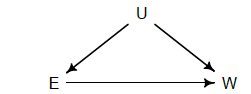

If we regress W on E, the estimate of the causal effect will be confounded by U. It is confounded,
because there are two paths connecting E and W: (1) E → W and (2) E ← U → W.
A “path” here just means any series of variables you could walk through to get from one variable
to another, ignoring the directions of the arrows. Both of these paths create a statistical
association between E and W. But only the first path is causal. The second path is non-causal.
Why? Because if only the second path existed, and we changed E, it would not change W.
Any causal influence of E on W operates only on the first path.
How can we isolate the causal path? The most famous solution is to run an experiment.
If we could assign education levels at random, it changes the graph:

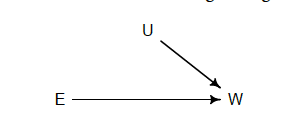

Manipulation removes the influence of U on E. The unobserved variables do not influence
education when we ourselves determine education. With the influence of U removed from
E, this then removes the path E ← U → W. It blocks the second path. Once the path is
blocked, there is only one way for information to go between E and W, and then measuring
the association between E and W would yield a useful measure of causal influence. Manipulation
removes the confounding, because it blocks the other path between E and W.

Luckily, there are statistical ways to achieve the same result, without actually manipulating
E. How? The most obvious is to add U to the model, to condition on U. Why does this
also remove the confounding? Because it also blocks the flow of information between E and
W through U. It blocks the second path.


To understand why conditioning on U blocks the path E ← U → W, think of this path in
isolation, as a complete model. Once you learn U, also learning E will give you no additional
information about W. Suppose for example that U is the average wealth in a region. Regions
with high wealth have better schools, resulting in more education E, as well as better paying
jobs, resulting in higher wages W. If you don’t know the region a person lives in, learning
the person’s education E will provide information about their wages W, because E and W are
correlated across regions. But after you learn which region a person lives in, assuming there
is no other path between E and W, then learning E tells you nothing about W.

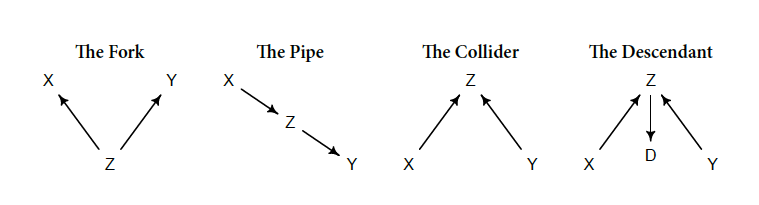

<h2>Shutting the backdoor</h2>. Blocking all confounding paths between some predictor X
and some outcome Y is known as shutting the backdoor. The metaphor in play is that we
don’t want any spurious correlation sneaking in through a non-causal path, which is one that
enters the back of the predictor X. In the example above, the path E ← U → W is a backdoor
path, because it enters E with an arrow and also connects E to W. This path is confounding.


Now for some good news. Given a causal DAG, it is always possible to say which, if any,
variables one must control for in order to shut all the backdoor paths. It is also possible to
say which variables one must not control for, in order to leave the path of interest open.
And—some more good news—there are only four types of variable relations that combine
to form all possible paths. So you really only need to understand four things and how
information flows in each of them.

Figure 6.6 shows DAGs for each elemental relation. Every DAG, no matter how big and
complicated, is built out of these four relations. Let’s consider each, going left to right.

(1) The first type of relation is the one we worked with just above, a fork: X ← Z → Y.
This is the classic confounder. In a fork, some variable Z is a common cause of X
and Y, generating a correlation between them. If we condition on Z, then learning
X tells us nothing about Y. X and Y are independent, conditional on Z.

(2) The second type of relation is a pipe: X → Z → Y. We saw this when we discussed
the plant growth example and post-treatment bias: The treatment X influences fungus
Z which influences growth Y. If we condition on Z now, we also block the path
from X to Y. So in both a fork and a pipe, conditioning of the middle variable
blocks the path.

(3) The third type of relation is a collider: X → Z ← Y. You met colliders earlier
in this chapter. Unlike the other two types of relations, in a collider there is no
association between X and Y unless you condition on Z. Conditioning on Z, the
collider variable, opens the path. Once the path is open, information flows between
X and Y.

(4) The fourth bit of knowledge you need is that conditioning on a descendent variable
is like conditioning on the variable itself, but weaker. A descendent is a variable
influenced by another variable. In the far right DAG in Figure 6.6, controlling for
D will also control, to a lesser extent, for Z. The reason is that D has some information
about Z. This will (partially) open the path from X to Y, because Z is a collider.
The same holds for non-colliders. If you condition on a descendent of Z in the pipe,
it’ll still be like (weakly) closing the pipe.

No matter how complicated a causal DAG appears, it is always built out of these four
types of relations. And since you know how to open and close each, you (or your computer)
can figure out which variables you need to control—or not—in order to shut the backdoor.
Here’s the recipe:

(1) List all of the paths connecting X (the potential cause of interest) and Y (the outcome).
(2) Classify each path by whether it is open or closed. A path is open unless it contains
a collider.
(3) Classify each path by whether it is a backdoor path. A backdoor path has an arrow
entering X.
(4) If there are any backdoor paths that are also open, decide which variable(s) to condition
on to close it.

The DAG below contains an exposure of interest X, an outcome of interest
Y, an unobserved variable U, and three observed covariates (A, B, and C).

We are interested in the blue path, the causal effect of X on Y. Which of the observed covariates
do we need to add to the model, in order to correctly infer it? To figure this out, look
for backdoor paths.

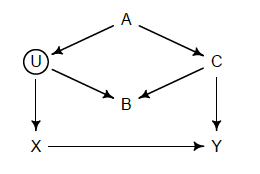

Aside from the direct path, there are two paths from X to Y:

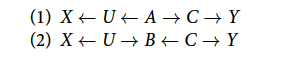

These are both backdoor paths that could confound inference. Now ask which of these paths
is open. If a backdoor path is open, then we must close it. If a backdoor path is closed already,
then we must not accidentally open it and create a confound.

Consider the first path, passing through A. This path is open, because there is no collider
within it. There is just a fork at the top and two pipes, one on each side. Information will
flow through this path, confounding X → Y. It is a backdoor. To shut this backdoor, we
need to condition on one of its variables. We can’t condition on U, since it is unobserved.
That leaves A or C. Either will shut the backdoor.


Now consider the second path, passing through B. This path does contain a collider, U →
B ← C. It is therefore already closed. You don’t need to control for B. But if we do condition on B, it is not
harmless. It will open the path, creating a confound. Then our inference about X → Y will
change, but without the DAG, we won’t know whether that change is helping us or rather
misleading us.




In [36]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)


frozenset({'A'})
frozenset({'C'})


Since the path does contain a collider, U →
B ← C, It is therefore already closed. It is not a backdoor, and that is why adjustmentSets
above did not mention B.